In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = r'/Users/mkopczynski/Desktop/engineer-diploma/model/data/Dataset_emotions/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 25088 images belonging to 5 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = r'/Users/mkopczynski/Desktop/engineer-diploma/model/data/Dataset_emotions/valid',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7898 images belonging to 5 classes.


In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

58889256/58889256 [==============================] - 9s 0us/step


In [7]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))


In [9]:
model.summary()
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_dataset,validation_data=test_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

/Users/mkopczynski/mambaforge/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


392/392 [==============================] - 41s 106ms/step - loss: 1.4625 - accuracy: 0.3379 - val_loss: 1.4739 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 3/100
392/392 [==============================] - 40s 103ms/step - loss: 1.4016 - accuracy: 0.3685 - val_loss: 1.4441 - val_accuracy: 0.3536 - lr: 0.0010
Epoch 4/100
392/392 [==============================] - 41s 104ms/step - loss: 1.3761 - accuracy: 0.3802 - val_loss: 1.3520 - val_accuracy: 0.3790 - lr: 0.0010
Epoch 5/100
392/392 [==============================] - 41s 104ms/step - loss: 1.3828 - accuracy: 0.3773 - val_loss: 1.6959 - val_accuracy: 0.2874 - lr: 0.0010
Epoch 6/100
392/392 [==============================] - 42s 107ms/step - loss: 1.3666 - accuracy: 0.3899 - val_loss: 1.4990 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 7/100
392/392 [==============================] - 41s 103ms/step - loss: 1.3482 - accuracy: 0.4049 - val_loss: 1.5078 - val_accuracy: 0.3541 - lr: 0.0010
Epoch 8/100
392/392 [==============================] - 43s

124/124 [==============================] - 8s 66ms/step


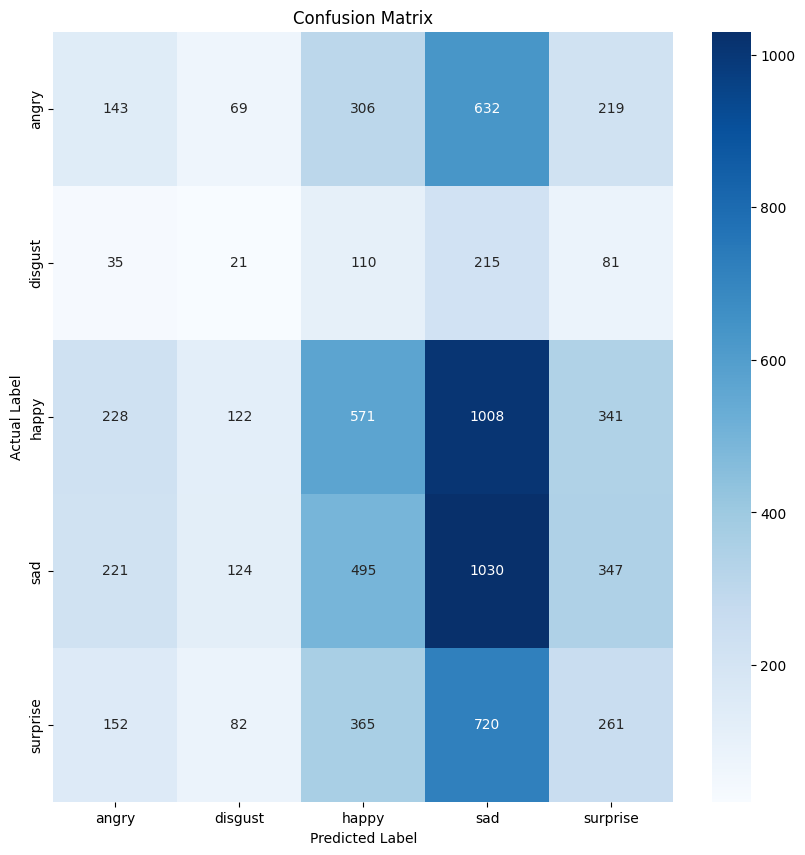

In [10]:
# 1. Calculate predictions on your test set.
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = test_dataset.classes

# Convert categorical predictions and actuals to class labels
class_labels = list(test_dataset.class_indices.keys())

# 2. Generate a confusion matrix and classification report.
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# 3. Save and visualize the confusion matrix as a png.
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix_vgg16.png")
plt.show()

# 4. Save the classification report to a CSV.
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report_vgg16.csv")
